In [1]:
!pip install wandb
!pip install 'transformers[torch]'
!pip install datasets 

In [2]:
import wandb
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix

from transformers import AutoTokenizer, AutoModelForSequenceClassification, default_data_collator, XLMRobertaForSequenceClassification

from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

from IPython.display import clear_output
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2024-04-05 19:47:02.409444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 19:47:02.409587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 19:47:02.681655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def calc_metrics(y_true, y_pred):
    y_true = y_true.cpu()
    y_pred = y_pred.cpu()
    
    res = confusion_matrix(y_true, y_pred).ravel()
    if len(res) == 1:
        if y_true[0] == 0:
            tn, fp, fn, tp = res[0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, res[0]
    else:
        tn, fp, fn, tp = res
    
    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, zero_division=0), recall_score(y_true, y_pred, zero_division=0), f1_score(y_true, y_pred, zero_division=0), tn, fp, fn, tp

@torch.no_grad()
def test(model, loader, device, tqdm_desc):
    loss_log = []
    acc_log = []
    prec_log = []
    rec_log = []
    f1_log = []
    
    tn_log = []
    fp_log = []
    fn_log = []
    tp_log = []
    
    model.eval()
    loss_func = nn.CrossEntropyLoss(weight=torch.tensor([0.73, 0.27]).to(device))

    for input_ids, attention_mask, labels in loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        out = model(input_ids, attention_mask=attention_mask)
        loss = loss_func(out.logits, labels)

        loss_log.append(loss.item())

        pred = torch.argmax(out.logits, dim=1)
        res = calc_metrics(labels, pred)
        acc_log.append(res[0])
        prec_log.append(res[1])
        rec_log.append(res[2])
        f1_log.append(res[3])
        tn_log.append(res[4])
        fp_log.append(res[5])
        fn_log.append(res[6])
        tp_log.append(res[7])

    return loss_log, acc_log, prec_log, rec_log, f1_log, tn_log, fp_log, fn_log, tp_log


def train(model, optimizer, n_epochs, train_loader, val_loader, batch_size, scheduler=None, log_batch_count=500, preval=True):    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    train_tn = []
    train_fp = []
    train_fn = []
    train_tp = []
    
    run = wandb.init(project='html classificator', reinit=True)
    wandb.watch(model, nn.CrossEntropyLoss(weight=torch.tensor([0.73, 0.27]).to(device)), log="all", log_freq=100)
    model.train()

    batch = 0
    loss_func = nn.CrossEntropyLoss(weight=torch.tensor([0.73, 0.27]).to(device))
    
    
    if preval:
        print(f"Init loss:")
        val_loss, val_acc, val_prec, val_rec, val_f1, val_tn, val_fp, val_fn, val_tp = test(model, val_loader, device, tqdm_desc='Validating')
        model.train()

        wandb.log({"val": {"acc": np.mean(val_acc), "pre": np.mean(val_prec), "rec": np.mean(val_rec), "f1": np.mean(val_f1), "loss": np.mean(val_loss), 
                           "true neg": np.mean(val_tn), "false pos": np.mean(val_fp), "false neg": np.mean(val_fn), "true pos": np.mean(val_tp)}})
        
        print(f" val loss: {np.mean(val_loss)}, val acc: {np.mean(val_acc)}\n")
    
    for epoch in range(n_epochs):
        for input_ids, attention_mask, labels in tqdm(train_loader, desc=f'Training {epoch}/{n_epochs}'):
            batch += 1
            
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            out = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = loss_func(out.logits, labels)
            loss.backward()
            optimizer.step()
            
            if batch <= 5:
                proba = F.softmax(out.logits, dim=-1)
                proba = proba.cpu()
                wandb.log({"proba": wandb.Histogram(proba.detach().numpy())})

            train_loss.append(loss.item())

            pred = torch.argmax(out.logits, dim=1)
            res = calc_metrics(labels, pred)
            train_acc.append(res[0])
            train_prec.append(res[1])
            train_rec.append(res[2])
            train_f1.append(res[3])
            train_tn.append(res[4])
            train_fp.append(res[5])
            train_fn.append(res[6])
            train_tp.append(res[7])
            
            if batch == log_batch_count:
                batch = 0
                
                val_loss, val_acc, val_prec, val_rec, val_f1, val_tn, val_fp, val_fn, val_tp = test(model, val_loader, device, tqdm_desc='Validating')
                model.train()
                
                wandb.log({"train": {"acc": np.mean(train_acc), "pre": np.mean(train_prec), "rec": np.mean(train_rec), "f1": np.mean(train_f1), "loss": np.mean(train_loss), 
                                     "true neg": np.mean(train_tn), "false pos": np.mean(train_fp), "false neg": np.mean(train_fn), "true pos": np.mean(train_tp)}, 
                           "val": {"acc": np.mean(val_acc), "pre": np.mean(val_prec), "rec": np.mean(val_rec), "f1": np.mean(val_f1), "loss": np.mean(val_loss), 
                                   "true neg": np.mean(val_tn), "false pos": np.mean(val_fp), "false neg": np.mean(val_fn), "true pos": np.mean(val_tp)}})
                
                # clear_output()
#                 print(f"Next 100 batches:")
#                 print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
#                 print(f" val loss: {np.mean(val_loss)}, val acc: {np.mean(val_acc)}\n")
                train_loss = []
                train_acc = []
                train_prec = []
                train_rec = []
                train_f1 = []
                train_tn = []
                train_fp = []
                train_fn = []
                train_tp = []

        if scheduler is not None:
            scheduler.step()
            
    # последние батчи
    val_loss, val_acc, val_prec, val_rec, val_f1, val_tn, val_fp, val_fn, val_tp = test(model, val_loader, device, tqdm_desc='Validating')
                
    wandb.log({"train": {"acc": np.mean(train_acc), "pre": np.mean(train_prec), "rec": np.mean(train_rec), "f1": np.mean(train_f1), "loss": np.mean(train_loss), 
                         "true neg": np.mean(train_tn), "false pos": np.mean(train_fp), "false neg": np.mean(train_fn), "true pos": np.mean(train_tp)}, 
                "val": {"acc": np.mean(val_acc), "pre": np.mean(val_prec), "rec": np.mean(val_rec), "f1": np.mean(val_f1), "loss": np.mean(val_loss), 
                        "true neg": np.mean(val_tn), "false pos": np.mean(val_fp), "false neg": np.mean(val_fn), "true pos": np.mean(val_tp)}})
    print(f"Last batches:")
    print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
    print(f" val loss: {np.mean(val_loss)}, val acc: {np.mean(val_acc)}\n")

    wandb.unwatch()
    run.finish()

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
wandb.login(key="eba16103be2afd0b5c96243771d60f5d7e562f68")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **Обрабатываем данные**

In [6]:
table_path = "/kaggle/input/site-bin-class/pars_data.csv"
data = pd.read_csv(table_path, on_bad_lines='skip', sep=';', lineterminator='\n')
data.dropna(axis=0, how='any', inplace=True)
data.text = data.text.astype(str)

dataset = Dataset.from_pandas(data)

In [8]:
data.head()

,text,target
0,индивидуальные групповые занятия будни выходны...,1
1,royal life федеральное театральное агентство «...,0
2,автоматизированная система uontravel войти заб...,0
3,уходовая домашняя косметика для души тела зада...,0
4,новости обучение трейдингу нуля обучение трейд...,1


In [9]:
print('общий размер датасета', data.shape[0])
print('количество элементов не из образования', data[data['target'] == 0]['text'].count())
print('количество элементов из образования', data[data['target'] == 1]['text'].count())
print('максимальный размер строки в датасете', max(len(i) for i in data['text']))

общий размер датасета 47621
количество элементов не из образования 34656
количество элементов из образования 12965
максимальный размер строки в датасете 1339641


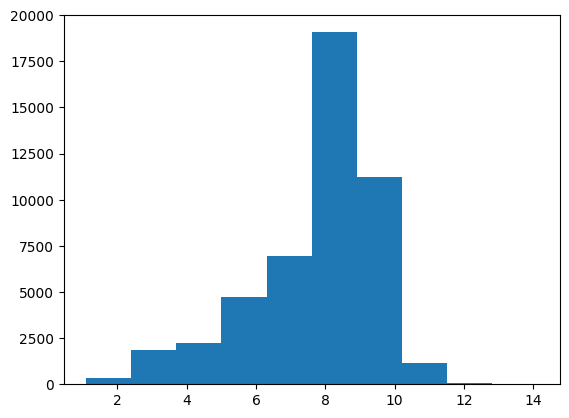

In [11]:
# гистог по лог от размера строки

plt.hist(np.log([len(i) for i in data['text']]))
plt.show()

In [14]:
np.exp(10)

22026.465794806718

# **Инициализируем модель и токенайзер (обрабатываем текст)**

In [10]:
# Load model directly

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model = XLMRobertaForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base").to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
%%time

TEST_SIZE = 0.3
SPLIT_RANDOM_SEED = 42
MAX_LENGTH = 512

def encode(examples):
    result = tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTH, padding="max_length")
    return result

tokenized_datasets = dataset.map(encode, batched=True, remove_columns="text")

  0%|          | 0/48 [00:00<?, ?ba/s]

CPU times: user 8min 17s, sys: 1.85 s, total: 8min 19s
Wall time: 2min 25s


In [7]:
%%time


input_ids_train, input_ids_v, attention_mask_train, attention_mask_v, label_train, label_v = train_test_split(torch.tensor(tokenized_datasets['input_ids']), 
                                                                                                  torch.tensor(tokenized_datasets['attention_mask']), 
                                                                                                  torch.tensor(tokenized_datasets['target']), 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=TEST_SIZE, shuffle=True)

input_ids_val, input_ids_test, attention_mask_val, attention_mask_test, label_val, label_test = train_test_split(input_ids_v, attention_mask_v, label_v, 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=0.33, shuffle=True)

train_dataset = TensorDataset(input_ids_train, attention_mask_train, label_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, label_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, label_test)

CPU times: user 47 s, sys: 780 ms, total: 47.8 s
Wall time: 47.5 s


In [8]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Базовая модель (512 размер строки)**

In [12]:
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Training 0/3:  24%|██▍       | 500/2084 [19:33<47:37:06, 108.22s/it]

Next 100 batches:
 train loss: 0.3438436353430152, train acc: 0.84425
 val loss: 0.25169663431623546, val acc: 0.8907554257095158



Training 0/3:  48%|████▊     | 1000/2084 [39:11<32:32:22, 108.07s/it]

Next 100 batches:
 train loss: 0.2522452085465193, train acc: 0.8975
 val loss: 0.25980170067082564, val acc: 0.8956594323873122



Training 0/3:  72%|███████▏  | 1500/2084 [58:50<17:32:11, 108.10s/it]

Next 100 batches:
 train loss: 0.2665684026386589, train acc: 0.884
 val loss: 0.24996682507093243, val acc: 0.8904424040066778



Training 0/3:  96%|█████████▌| 2000/2084 [1:18:28<2:31:26, 108.17s/it]

Next 100 batches:
 train loss: 0.2653320294730365, train acc: 0.88825
 val loss: 0.43475175078317696, val acc: 0.8143781302170284



Training 1/3:  20%|█▉        | 416/2084 [17:19<50:08:09, 108.21s/it]

Next 100 batches:
 train loss: 0.25335297762602565, train acc: 0.890375
 val loss: 0.24690760237449322, val acc: 0.899728714524207



Training 1/3:  44%|████▍     | 916/2084 [36:58<35:04:58, 108.13s/it]

Next 100 batches:
 train loss: 0.25718214244768023, train acc: 0.892125
 val loss: 0.23911151059052732, val acc: 0.898059265442404



Training 1/3:  68%|██████▊   | 1416/2084 [56:39<20:10:49, 108.76s/it]

Next 100 batches:
 train loss: 0.2524174031764269, train acc: 0.8965
 val loss: 0.2548285537509742, val acc: 0.8944073455759599



Training 1/3:  92%|█████████▏| 1916/2084 [1:16:19<5:03:03, 108.24s/it]

Next 100 batches:
 train loss: 0.2632292756102979, train acc: 0.884625
 val loss: 0.2556516764940498, val acc: 0.8961811352253757



Training 2/3:  16%|█▌        | 332/2084 [15:00<52:39:04, 108.19s/it]

Next 100 batches:
 train loss: 0.2546376099102199, train acc: 0.8899166666666666
 val loss: 0.23969308298410777, val acc: 0.8973288814691152



Training 2/3:  40%|███▉      | 832/2084 [34:40<37:38:38, 108.24s/it]

Next 100 batches:
 train loss: 0.24277572084218263, train acc: 0.895625
 val loss: 0.24984589096419949, val acc: 0.9010851419031719



Training 2/3:  64%|██████▍   | 1332/2084 [54:19<22:37:33, 108.32s/it]

Next 100 batches:
 train loss: 0.24453319256380202, train acc: 0.89575
 val loss: 0.23990811820364308, val acc: 0.8995200333889817



Training 2/3:  88%|████████▊ | 1832/2084 [1:13:57<7:34:22, 108.18s/it]

Next 100 batches:
 train loss: 0.24176935820281506, train acc: 0.897375
 val loss: 0.2338708041232695, val acc: 0.9017111853088481



Training 2/3: 100%|██████████| 2084/2084 [1:20:55<00:00,  2.33s/it]   


Last batches:
 train loss: 0.24218072983184977, train acc: 0.8946759259259259
 val loss: 0.23673500844241682, val acc: 0.9010851419031719



In [13]:
test_loss, test_acc, test_prec, test_rec, test_f1 = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.22772546339211827, accuracy = 0.9044491525423729, precision = 0.8426836158192089, recall = 0.7995466774280334, f1_score = 0.798695709903665


[xlm-roberta-base-binclass](https://wandb.ai/rodion-chernomordin/html%20classificator/runs/3pdqqtr8?nw=nwuserrodionchernomordin)

# **Заморозим все параметры базовой robert (512 размер строки)**

In [61]:
for param in model.roberta.parameters():
    param.requires_grad = False

In [62]:
%%time

optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, True)

Init loss:
 val loss: 0.606423469686349, val acc: 0.7298622704507512



Training 2/3: 100%|██████████| 2084/2084 [45:19<00:00,  1.31s/it]    


Last batches:
 train loss: 0.5201510729061233, train acc: 0.7455357142857143
 val loss: 0.5301524343494581, val acc: 0.7298622704507512



CPU times: user 2h 35min 37s, sys: 5min 45s, total: 2h 41min 22s
Wall time: 2h 28min 24s


In [64]:
test_loss, test_acc, test_prec, test_rec, test_f1, _, _, _, _ = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.5321233773635605, accuracy = 0.7283127889060093, precision = 0.0, recall = 0.0, f1_score = 0.0


[xlm-robert-binclass-freeze](https://wandb.ai/rodion-chernomordin/html%20classificator/runs/u099nudh?nw=nwuserrodionchernomordin)

# **Добавим веса в лосс**

In [71]:
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, True)

Init loss:
 val loss: 0.6779123802415915, val acc: 0.7299666110183639



Training 2/3: 100%|██████████| 2084/2084 [1:27:22<00:00,  2.52s/it]   


Last batches:
 train loss: 0.19234290890883476, train acc: 0.8714451058201058
 val loss: 0.1711773048364907, val acc: 0.8857470784641068



In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1, _, _, _, _ = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

[xlm-robert-binclass-weightloss](https://wandb.ai/rodion-chernomordin/html%20classificator/runs/ggln5kmp?nw=nwuserrodionchernomordin)

# **Логируем каждый батч, но одну эпоху (иначе умру) - полная модель с парам лоссом**

In [11]:
%%time

optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 1, train_loader, val_loader, batch_size, scheduler, 1, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Init loss:
 val loss: 0.6361564451545626, val acc: 0.7298622704507512



Training 0/1:   0%|          | 10/2084 [1:03:49<220:38:33, 382.99s/it]


KeyboardInterrupt: 

[xlm-robert-binclass-f10b](https://wandb.ai/rodion-chernomordin/html%20classificator/runs/p21a1qcp?nw=nwuserrodionchernomordin)

# **Попробуем взять текст размера 2к**

In [8]:
%%time

TEST_SIZE = 0.3
SPLIT_RANDOM_SEED = 42
MAX_LENGTH = 2000

def encode(examples):
    result = tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTH, padding="max_length")
    return result

tokenized_datasets = dataset.map(encode, batched=True, remove_columns="text")

  0%|          | 0/48 [00:00<?, ?ba/s]

CPU times: user 8min 40s, sys: 3.94 s, total: 8min 44s
Wall time: 2min 54s


In [9]:
%%time


input_ids_train, input_ids_v, attention_mask_train, attention_mask_v, label_train, label_v = train_test_split(torch.tensor(tokenized_datasets['input_ids']), 
                                                                                                  torch.tensor(tokenized_datasets['attention_mask']), 
                                                                                                  torch.tensor(tokenized_datasets['target']), 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=TEST_SIZE, shuffle=True)

input_ids_val, input_ids_test, attention_mask_val, attention_mask_test, label_val, label_test = train_test_split(input_ids_v, attention_mask_v, label_v, 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=0.33, shuffle=True)

train_dataset = TensorDataset(input_ids_train, attention_mask_train, label_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, label_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, label_test)

CPU times: user 3min 2s, sys: 2.98 s, total: 3min 5s
Wall time: 3min 3s


In [10]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
%%time

optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Init loss:


RuntimeError: The expanded size of the tensor (2000) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [16, 2000].  Tensor sizes: [1, 514]

У нас может быть размер строки не больше 514 (2к не подойдут)

# **Посмотрим сколько по времени без всего обучается одна эпоха**

In [9]:
def only_train(model, optimizer, n_epochs, train_loader, val_loader, batch_size, scheduler=None, log_batch_count=500, preval=True):    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model.train()
    batch = 0
    loss_func = nn.CrossEntropyLoss(weight=torch.tensor([0.73, 0.27]).to(device))
    
    for epoch in range(n_epochs):
        for input_ids, attention_mask, labels in tqdm(train_loader, desc=f'Training {epoch}/{n_epochs}'):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            out = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = loss_func(out.logits, labels)
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

In [10]:
%%time

optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
only_train(model, optimizer, 1, train_loader, val_loader, batch_size, scheduler, 500, True)

Training 1/3:   2%|▏         | 35/2084 [00:55<53:49,  1.58s/it]


KeyboardInterrupt: 

54:34

# **Проверка на переобучение**

In [9]:
input_ids_train, input_ids_v, attention_mask_train, attention_mask_v, label_train, label_v = train_test_split(torch.tensor(tokenized_datasets['input_ids']), 
                                                                                                  torch.tensor(tokenized_datasets['attention_mask']), 
                                                                                                  torch.tensor(tokenized_datasets['target']), 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=TEST_SIZE, shuffle=True)

input_ids_val, input_ids_test, attention_mask_val, attention_mask_test, label_val, label_test = train_test_split(input_ids_v, attention_mask_v, label_v, 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=0.33, shuffle=True)

In [10]:
new_train_size = 1024

print(input_ids_train.shape)
input_ids_train, attention_mask_train, label_train = input_ids_train[:new_train_size], attention_mask_train[:new_train_size], label_train[:new_train_size]
print(input_ids_train.shape)

torch.Size([33334, 512])
torch.Size([1024, 512])


In [11]:
train_dataset = TensorDataset(input_ids_train, attention_mask_train, label_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, label_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, label_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
%%time

optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 10, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Init loss:
 val loss: 0.6569885929956261, val acc: 0.7298622704507512



Training 2/3: 100%|██████████| 64/64 [45:24<00:00, 42.56s/it]   


Last batches:
 train loss: 0.3114948272705078, train acc: 0.59375
 val loss: 0.23224324491092677, val acc: 0.7298622704507512



CPU times: user 2h 23min 2s, sys: 5min 24s, total: 2h 28min 26s
Wall time: 2h 17min 1s


In [13]:
test_loss, test_acc, test_prec, test_rec, test_f1, _, _, _, _ = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.23473065966519258, accuracy = 0.7283127889060093, precision = 0.0, recall = 0.0, f1_score = 0.0


[xlm-robert-binclass-overfitting](https://wandb.ai/rodion-chernomordin/html%20classificator/runs/3szcvqqc?nw=nwuserrodionchernomordin)

# **Проверка на здравие (ставим рандомные таргеты)**

In [14]:
table_path = "/kaggle/input/site-bin-class/pars_data.csv"
data = pd.read_csv(table_path, on_bad_lines='skip', sep=';', lineterminator='\n')
data.dropna(axis=0, how='any', inplace=True)
data.text = data.text.astype(str)

print(data.target.tolist()[:100])
target = data.target.tolist()
np.random.shuffle(target)
data.target = target
print(data.target.tolist()[:100])

dataset = Dataset.from_pandas(data)

[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


In [15]:
%%time

TEST_SIZE = 0.3
SPLIT_RANDOM_SEED = 42
MAX_LENGTH = 512

def encode(examples):
    result = tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTH, padding="max_length")
    return result

tokenized_datasets = dataset.map(encode, batched=True, remove_columns="text")

  0%|          | 0/48 [00:00<?, ?ba/s]

CPU times: user 8min 13s, sys: 1.57 s, total: 8min 14s
Wall time: 2min 23s


In [16]:
%%time

input_ids_train, input_ids_v, attention_mask_train, attention_mask_v, label_train, label_v = train_test_split(torch.tensor(tokenized_datasets['input_ids']), 
                                                                                                  torch.tensor(tokenized_datasets['attention_mask']), 
                                                                                                  torch.tensor(tokenized_datasets['target']), 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=TEST_SIZE, shuffle=True)

input_ids_val, input_ids_test, attention_mask_val, attention_mask_test, label_val, label_test = train_test_split(input_ids_v, attention_mask_v, label_v, 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=0.33, shuffle=True)

train_dataset = TensorDataset(input_ids_train, attention_mask_train, label_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, label_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, label_test)

CPU times: user 49.4 s, sys: 929 ms, total: 50.3 s
Wall time: 49.9 s


In [17]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
%%time

optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Init loss:
 val loss: 0.8247480937753974, val acc: 0.27775459098497496



Training 2/3: 100%|██████████| 2084/2084 [1:17:09<00:00,  2.22s/it]   


Last batches:
 train loss: 0.38367511574474594, train acc: 0.7272652116402116
 val loss: 0.38769419136797645, val acc: 0.7222454090150251



CPU times: user 3h 59min 10s, sys: 17min 24s, total: 4h 16min 35s
Wall time: 4h 3min 8s


In [19]:
test_loss, test_acc, test_prec, test_rec, test_f1, _, _, _, _ = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.38188206927251006, accuracy = 0.7281972265023112, precision = 0.0, recall = 0.0, f1_score = 0.0


[xlm-robert-binclass-trash](https://wandb.ai/rodion-chernomordin/html%20classificator/runs/jrehvyvk?nw=nwuserrodionchernomordin)

# **Чистка памяти**

In [17]:
import gc
torch.cuda.empty_cache()
gc.collect()

0